# Creating the baseline model

Let's create a baseline model on the raw data, with no data manipulation 

All the images are pretty much uniform so let's just see what a baseline score could be
From there, we can always improve

In [22]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [23]:
base_dir = "../raw_data"

for root, dirs, files in os.walk(base_dir):
    print(root, ":", len(files))

../raw_data : 1
../raw_data/contempt : 208
../raw_data/fear : 570
../raw_data/surprise : 775
../raw_data/sadness : 746
../raw_data/neutrality : 524
../raw_data/happiness : 1406
../raw_data/anger : 890
../raw_data/disgust : 439


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


In [35]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(224,224),
    color_mode="grayscale",
    batch_size=32,
    label_mode="categorical"   # one-hot encoding
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=(224,224),
    color_mode="grayscale",
    batch_size=32,
    label_mode="categorical"
)

# Count how many batches are in your current validation set
val_batches = tf.data.experimental.cardinality(val_ds)

# Define test size (here: 50% of your current val_ds)
test_size = val_batches // 2

# Take half for test, keep the other half as validation
test_ds = val_ds.take(test_size)
val_ds  = val_ds.skip(test_size)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Found 5558 files belonging to 8 classes.
Using 3891 files for training.
Found 5558 files belonging to 8 classes.
Using 1667 files for validation.
Train batches: 122
Validation batches: 27
Test batches: 26


In [36]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

2025-09-02 10:44:07.834887: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:44:07.841505: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:44:07.847582: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:44:07.865026: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:44:07.881438: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:44:07.882983: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02

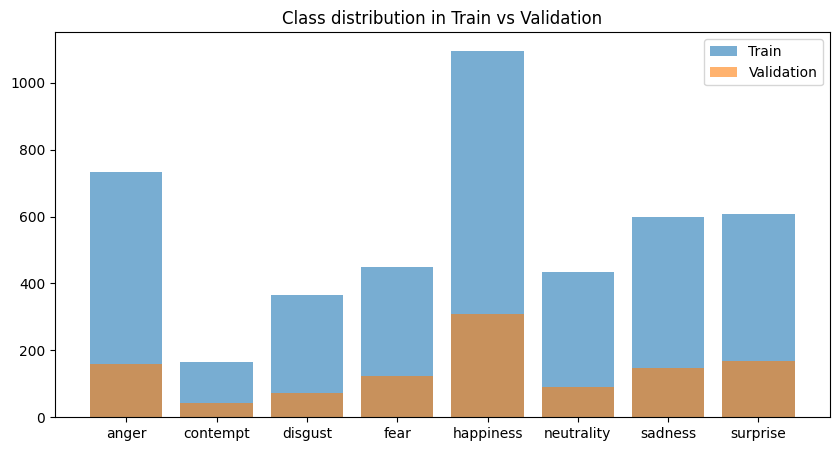

In [27]:
def get_label_distribution(dataset):
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(np.argmax(labels.numpy(), axis=1))  # convert one-hot → class index
    return np.array(all_labels)

train_labels = get_label_distribution(train_ds)
val_labels = get_label_distribution(val_ds)

# Count occurrences
train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)

class_names = train_ds.class_names

plt.figure(figsize=(10,5))
plt.bar(class_names, train_counts, alpha=0.6, label="Train")
plt.bar(class_names, val_counts, alpha=0.6, label="Validation")
plt.legend()
plt.title("Class distribution in Train vs Validation")
plt.show()

In [28]:
def get_label_counts(dataset, class_names, one_hot=True):
    all_labels = []
    for _, labels in dataset:
        if one_hot:
            all_labels.extend(np.argmax(labels.numpy(), axis=1))  # one-hot → class index
        else:
            all_labels.extend(labels.numpy())  # already integers
    counts = np.bincount(all_labels, minlength=len(class_names))
    return counts

In [21]:
one_hot = True   # set to False if you used label_mode="int"

train_counts = get_label_counts(train_ds, class_names, one_hot)
val_counts   = get_label_counts(val_ds, class_names, one_hot)

df_counts = pd.DataFrame({
    "Class": class_names,
    "Train Count": train_counts,
    "Validation Count": val_counts
})

display(df_counts)

2025-09-01 17:41:11.797001: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.817503: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.818205: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.825550: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.826967: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.828869: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01

,Class,Train Count,Validation Count
0,anger,732,158
1,contempt,164,44
2,disgust,366,73
3,fear,448,122
4,happiness,1096,310
5,neutrality,434,90
6,sadness,599,147
7,surprise,608,167


In [29]:
for images, labels in train_ds.take(1):  # take 1 batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("First label:", labels[0])

Images shape: (32, 224, 224, 1)
Labels shape: (32, 8)
First label: tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


2025-09-02 10:44:13.530392: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


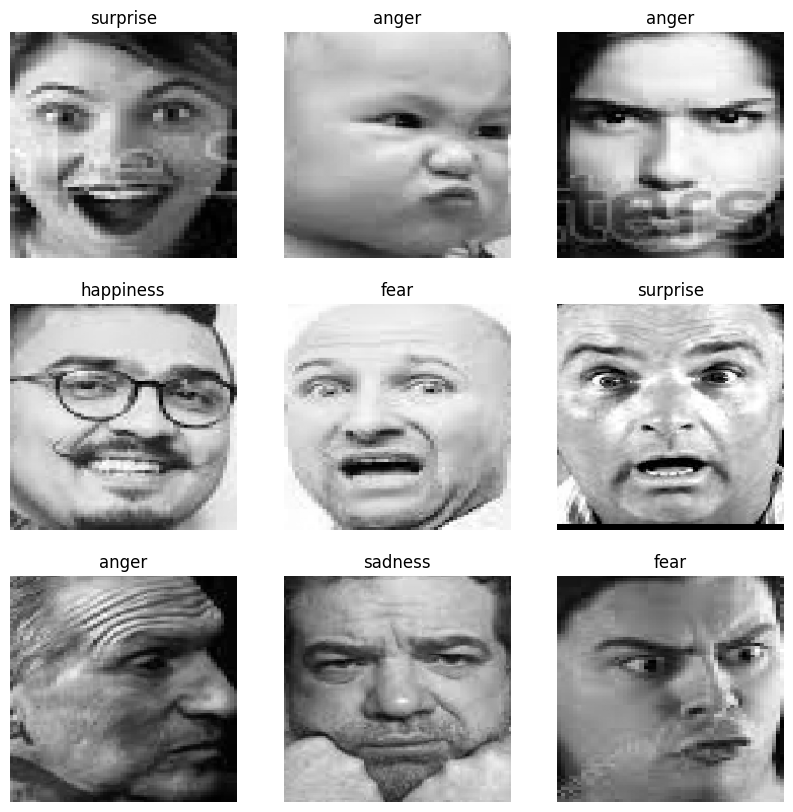

In [30]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        label_index = labels[i].numpy().argmax()  # if one-hot
        plt.title(class_names[label_index])
        plt.axis("off")

In [37]:
from tensorflow.keras import layers, models

num_classes = len(train_ds.class_names)

model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,600 (369.53 KB)

 Trainable params: 94,152 (367.78 KB)

 Non-trainable params: 448 (1.75 KB)

In [39]:


model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   # one-hot
    metrics=["accuracy"]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_baseline.keras", monitor="val_accuracy", save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


2025-09-02 10:51:54.306703: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:51:54.312003: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:51:54.329608: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  6/122 ━━━━━━━━━━━━━━━━━━━━ 1:27 751ms/step - accuracy: 0.1449 - loss: 2.3357

2025-09-02 10:51:59.088232: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/122 ━━━━━━━━━━━━━━━━━━━━ 1:26 769ms/step - accuracy: 0.1553 - loss: 2.2926

2025-09-02 10:52:02.256405: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 11/122 ━━━━━━━━━━━━━━━━━━━━ 1:24 764ms/step - accuracy: 0.1582 - loss: 2.2861

2025-09-02 10:52:02.968906: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 1:23 762ms/step - accuracy: 0.1615 - loss: 2.2787

2025-09-02 10:52:03.714430: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 14/122 ━━━━━━━━━━━━━━━━━━━━ 1:22 764ms/step - accuracy: 0.1664 - loss: 2.2675

2025-09-02 10:52:05.265319: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 15/122 ━━━━━━━━━━━━━━━━━━━━ 1:22 771ms/step - accuracy: 0.1681 - loss: 2.2628

2025-09-02 10:52:06.123395: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:06.125892: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/122 ━━━━━━━━━━━━━━━━━━━━ 1:20 793ms/step - accuracy: 0.1755 - loss: 2.2443

2025-09-02 10:52:11.193488: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:11.199036: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/122 ━━━━━━━━━━━━━━━━━━━━ 1:19 799ms/step - accuracy: 0.1762 - loss: 2.2419

2025-09-02 10:52:12.113209: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/122 ━━━━━━━━━━━━━━━━━━━━ 1:19 803ms/step - accuracy: 0.1768 - loss: 2.2396

2025-09-02 10:52:12.988986: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/122 ━━━━━━━━━━━━━━━━━━━━ 1:19 809ms/step - accuracy: 0.1774 - loss: 2.2373

2025-09-02 10:52:13.940565: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 26/122 ━━━━━━━━━━━━━━━━━━━━ 1:18 815ms/step - accuracy: 0.1789 - loss: 2.2324

2025-09-02 10:52:15.716287: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:15.720675: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 31/122 ━━━━━━━━━━━━━━━━━━━━ 1:15 835ms/step - accuracy: 0.1830 - loss: 2.2196

2025-09-02 10:52:20.371470: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/122 ━━━━━━━━━━━━━━━━━━━━ 1:13 840ms/step - accuracy: 0.1849 - loss: 2.2131

2025-09-02 10:52:23.059984: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:23.060398: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:23.061676: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/122 ━━━━━━━━━━━━━━━━━━━━ 1:12 839ms/step - accuracy: 0.1864 - loss: 2.2084

2025-09-02 10:52:24.692906: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:11 839ms/step - accuracy: 0.1873 - loss: 2.2059

2025-09-02 10:52:25.517138: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:25.518860: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 39/122 ━━━━━━━━━━━━━━━━━━━━ 1:09 840ms/step - accuracy: 0.1887 - loss: 2.2014

2025-09-02 10:52:27.255817: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 40/122 ━━━━━━━━━━━━━━━━━━━━ 1:09 842ms/step - accuracy: 0.1893 - loss: 2.1992

2025-09-02 10:52:28.160663: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 42/122 ━━━━━━━━━━━━━━━━━━━━ 1:07 848ms/step - accuracy: 0.1903 - loss: 2.1951

2025-09-02 10:52:30.118743: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 10:52:30.118780: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 48/122 ━━━━━━━━━━━━━━━━━━━━ 1:02 841ms/step - accuracy: 0.1925 - loss: 2.1844

2025-09-02 10:52:34.874729: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/122 ━━━━━━━━━━━━━━━━━━━━ 59s 842ms/step - accuracy: 0.1936 - loss: 2.1794 

2025-09-02 10:52:37.417684: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/122 ━━━━━━━━━━━━━━━━━━━━ 57s 842ms/step - accuracy: 0.1946 - loss: 2.1747

2025-09-02 10:52:39.968037: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:39.968314: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/122 ━━━━━━━━━━━━━━━━━━━━ 55s 843ms/step - accuracy: 0.1953 - loss: 2.1717

2025-09-02 10:52:41.678983: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 58/122 ━━━━━━━━━━━━━━━━━━━━ 54s 844ms/step - accuracy: 0.1958 - loss: 2.1687

2025-09-02 10:52:43.466222: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 59/122 ━━━━━━━━━━━━━━━━━━━━ 53s 848ms/step - accuracy: 0.1961 - loss: 2.1673

2025-09-02 10:52:44.534550: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/122 ━━━━━━━━━━━━━━━━━━━━ 51s 868ms/step - accuracy: 0.1972 - loss: 2.1615

2025-09-02 10:52:49.155464: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:49.158607: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 68/122 ━━━━━━━━━━━━━━━━━━━━ 47s 888ms/step - accuracy: 0.1988 - loss: 2.1547

2025-09-02 10:52:54.815685: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:52:54.818523: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 69/122 ━━━━━━━━━━━━━━━━━━━━ 47s 888ms/step - accuracy: 0.1991 - loss: 2.1534

2025-09-02 10:52:55.690035: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/122 ━━━━━━━━━━━━━━━━━━━━ 46s 887ms/step - accuracy: 0.1994 - loss: 2.1521

2025-09-02 10:52:56.548983: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/122 ━━━━━━━━━━━━━━━━━━━━ 45s 887ms/step - accuracy: 0.1997 - loss: 2.1507

2025-09-02 10:52:57.394144: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/122 ━━━━━━━━━━━━━━━━━━━━ 43s 888ms/step - accuracy: 0.2003 - loss: 2.1481

2025-09-02 10:52:59.254046: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 74/122 ━━━━━━━━━━━━━━━━━━━━ 42s 888ms/step - accuracy: 0.2005 - loss: 2.1469

2025-09-02 10:53:00.189082: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 79/122 ━━━━━━━━━━━━━━━━━━━━ 38s 888ms/step - accuracy: 0.2018 - loss: 2.1411

2025-09-02 10:53:04.579041: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 80/122 ━━━━━━━━━━━━━━━━━━━━ 37s 887ms/step - accuracy: 0.2021 - loss: 2.1399

2025-09-02 10:53:05.440612: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/122 ━━━━━━━━━━━━━━━━━━━━ 35s 886ms/step - accuracy: 0.2026 - loss: 2.1377

2025-09-02 10:53:07.132264: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:07.134119: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/122 ━━━━━━━━━━━━━━━━━━━━ 34s 886ms/step - accuracy: 0.2029 - loss: 2.1366

2025-09-02 10:53:07.964276: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/122 ━━━━━━━━━━━━━━━━━━━━ 31s 890ms/step - accuracy: 0.2037 - loss: 2.1326

2025-09-02 10:53:11.859985: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 95/122 ━━━━━━━━━━━━━━━━━━━━ 23s 888ms/step - accuracy: 0.2054 - loss: 2.1254

2025-09-02 10:53:18.833525: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/122 ━━━━━━━━━━━━━━━━━━━━ 23s 890ms/step - accuracy: 0.2056 - loss: 2.1246

2025-09-02 10:53:19.879081: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 99/122 ━━━━━━━━━━━━━━━━━━━━ 20s 891ms/step - accuracy: 0.2061 - loss: 2.1222

2025-09-02 10:53:22.626783: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/122 ━━━━━━━━━━━━━━━━━━━━ 19s 890ms/step - accuracy: 0.2063 - loss: 2.1214

2025-09-02 10:53:23.488880: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 18s 890ms/step - accuracy: 0.2065 - loss: 2.1206

2025-09-02 10:53:24.355233: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:24.360694: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/122 ━━━━━━━━━━━━━━━━━━━━ 17s 890ms/step - accuracy: 0.2067 - loss: 2.1198

2025-09-02 10:53:25.193638: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:25.195410: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/122 ━━━━━━━━━━━━━━━━━━━━ 15s 890ms/step - accuracy: 0.2072 - loss: 2.1175

2025-09-02 10:53:27.894766: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/122 ━━━━━━━━━━━━━━━━━━━━ 11s 891ms/step - accuracy: 0.2080 - loss: 2.1146

2025-09-02 10:53:31.525138: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:31.526534: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


111/122 ━━━━━━━━━━━━━━━━━━━━ 9s 891ms/step - accuracy: 0.2083 - loss: 2.1132 

2025-09-02 10:53:33.300270: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/122 ━━━━━━━━━━━━━━━━━━━━ 8s 890ms/step - accuracy: 0.2085 - loss: 2.1124

2025-09-02 10:53:34.152069: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:34.152994: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:34.159741: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


114/122 ━━━━━━━━━━━━━━━━━━━━ 7s 892ms/step - accuracy: 0.2089 - loss: 2.1111

2025-09-02 10:53:36.074177: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/122 ━━━━━━━━━━━━━━━━━━━━ 6s 892ms/step - accuracy: 0.2091 - loss: 2.1104

2025-09-02 10:53:37.016365: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:37.033372: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


117/122 ━━━━━━━━━━━━━━━━━━━━ 4s 893ms/step - accuracy: 0.2095 - loss: 2.1091

2025-09-02 10:53:38.875776: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.2104 - loss: 2.1061

2025-09-02 10:53:43.220202: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:43.221826: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:43.222302: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:43.223295: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:43.228612: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:43.228656: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02

122/122 ━━━━━━━━━━━━━━━━━━━━ 115s 931ms/step - accuracy: 0.2316 - loss: 2.0355 - val_accuracy: 0.0395 - val_loss: 2.2048
Epoch 2/20


2025-09-02 10:53:47.965306: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:47.980505: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/122 ━━━━━━━━━━━━━━━━━━━━ 1:47 897ms/step - accuracy: 0.2031 - loss: 1.9347

2025-09-02 10:53:49.878600: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/122 ━━━━━━━━━━━━━━━━━━━━ 1:53 960ms/step - accuracy: 0.1934 - loss: 1.9693

2025-09-02 10:53:51.861638: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:51.864559: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  5/122 ━━━━━━━━━━━━━━━━━━━━ 1:52 959ms/step - accuracy: 0.1884 - loss: 1.9864

2025-09-02 10:53:52.816726: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  6/122 ━━━━━━━━━━━━━━━━━━━━ 1:50 954ms/step - accuracy: 0.1883 - loss: 1.9977

2025-09-02 10:53:53.750005: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:53.758065: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/122 ━━━━━━━━━━━━━━━━━━━━ 1:47 941ms/step - accuracy: 0.1891 - loss: 2.0179

2025-09-02 10:53:55.566606: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 1:42 934ms/step - accuracy: 0.1986 - loss: 2.0228

2025-09-02 10:53:59.256889: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:53:59.256964: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 15/122 ━━━━━━━━━━━━━━━━━━━━ 1:38 924ms/step - accuracy: 0.2039 - loss: 2.0211

2025-09-02 10:54:01.923184: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 20/122 ━━━━━━━━━━━━━━━━━━━━ 1:33 919ms/step - accuracy: 0.2079 - loss: 2.0179

2025-09-02 10:54:06.442171: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 25/122 ━━━━━━━━━━━━━━━━━━━━ 1:28 914ms/step - accuracy: 0.2102 - loss: 2.0153

2025-09-02 10:54:10.910770: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:54:10.915749: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 26/122 ━━━━━━━━━━━━━━━━━━━━ 1:27 914ms/step - accuracy: 0.2104 - loss: 2.0146

2025-09-02 10:54:11.842620: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 29/122 ━━━━━━━━━━━━━━━━━━━━ 1:25 915ms/step - accuracy: 0.2111 - loss: 2.0133

2025-09-02 10:54:14.601658: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 30/122 ━━━━━━━━━━━━━━━━━━━━ 1:24 917ms/step - accuracy: 0.2113 - loss: 2.0129

2025-09-02 10:54:15.563039: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 31/122 ━━━━━━━━━━━━━━━━━━━━ 1:23 917ms/step - accuracy: 0.2115 - loss: 2.0125

2025-09-02 10:54:16.500658: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 33/122 ━━━━━━━━━━━━━━━━━━━━ 1:21 917ms/step - accuracy: 0.2120 - loss: 2.0118

2025-09-02 10:54:18.342453: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 39/122 ━━━━━━━━━━━━━━━━━━━━ 1:16 923ms/step - accuracy: 0.2132 - loss: 2.0097

2025-09-02 10:54:24.048216: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 10:54:24.048282: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:54:24.049687: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 40/122 ━━━━━━━━━━━━━━━━━━━━ 1:15 923ms/step - accuracy: 0.2134 - loss: 2.0095

2025-09-02 10:54:24.991540: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/122 ━━━━━━━━━━━━━━━━━━━━ 1:11 926ms/step - accuracy: 0.2148 - loss: 2.0081

2025-09-02 10:54:29.743583: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 48/122 ━━━━━━━━━━━━━━━━━━━━ 1:08 928ms/step - accuracy: 0.2154 - loss: 2.0072

2025-09-02 10:54:32.620525: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 49/122 ━━━━━━━━━━━━━━━━━━━━ 1:07 930ms/step - accuracy: 0.2156 - loss: 2.0069

2025-09-02 10:54:33.631641: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/122 ━━━━━━━━━━━━━━━━━━━━ 1:06 935ms/step - accuracy: 0.2159 - loss: 2.0063

2025-09-02 10:54:35.717804: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/122 ━━━━━━━━━━━━━━━━━━━━ 1:04 940ms/step - accuracy: 0.2163 - loss: 2.0054

2025-09-02 10:54:37.841777: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/122 ━━━━━━━━━━━━━━━━━━━━ 1:03 941ms/step - accuracy: 0.2166 - loss: 2.0050

2025-09-02 10:54:38.847523: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 55/122 ━━━━━━━━━━━━━━━━━━━━ 1:03 942ms/step - accuracy: 0.2168 - loss: 2.0045

2025-09-02 10:54:39.838548: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/122 ━━━━━━━━━━━━━━━━━━━━ 1:02 944ms/step - accuracy: 0.2171 - loss: 2.0040

2025-09-02 10:54:40.902669: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/122 ━━━━━━━━━━━━━━━━━━━━ 1:01 946ms/step - accuracy: 0.2173 - loss: 2.0035

2025-09-02 10:54:41.947998: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:54:41.948901: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 58/122 ━━━━━━━━━━━━━━━━━━━━ 1:00 948ms/step - accuracy: 0.2176 - loss: 2.0029

2025-09-02 10:54:43.015275: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/122 ━━━━━━━━━━━━━━━━━━━━ 56s 962ms/step - accuracy: 0.2190 - loss: 2.0004

2025-09-02 10:54:48.649929: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/122 ━━━━━━━━━━━━━━━━━━━━ 55s 965ms/step - accuracy: 0.2192 - loss: 2.0000

2025-09-02 10:54:49.771523: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:54:49.776546: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 66/122 ━━━━━━━━━━━━━━━━━━━━ 54s 972ms/step - accuracy: 0.2198 - loss: 1.9991

2025-09-02 10:54:52.184797: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:54:52.187511: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 68/122 ━━━━━━━━━━━━━━━━━━━━ 52s 980ms/step - accuracy: 0.2204 - loss: 1.9982

2025-09-02 10:54:54.619935: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/122 ━━━━━━━━━━━━━━━━━━━━ 48s 996ms/step - accuracy: 0.2217 - loss: 1.9961

2025-09-02 10:55:00.680306: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 74/122 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2220 - loss: 1.9958   

2025-09-02 10:55:01.998266: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 75/122 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2222 - loss: 1.9954

2025-09-02 10:55:03.277000: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 79/122 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2231 - loss: 1.9940

2025-09-02 10:55:09.075191: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/122 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2240 - loss: 1.9928

2025-09-02 10:55:14.328154: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:55:14.332569: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/122 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2242 - loss: 1.9924

2025-09-02 10:55:15.682111: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/122 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2248 - loss: 1.9916

2025-09-02 10:55:19.603424: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:55:19.603704: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:55:19.607355: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/122 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2252 - loss: 1.9911

2025-09-02 10:55:21.958288: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:55:21.958876: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 90/122 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2254 - loss: 1.9908

2025-09-02 10:55:23.149568: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 91/122 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2256 - loss: 1.9906

2025-09-02 10:55:24.273454: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 98/122 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2267 - loss: 1.9891

2025-09-02 10:55:33.400957: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 99/122 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2269 - loss: 1.9888

2025-09-02 10:55:34.815581: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:55:34.815635: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/122 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2271 - loss: 1.9886

2025-09-02 10:55:36.284908: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2273 - loss: 1.9883

2025-09-02 10:55:37.965309: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/122 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2274 - loss: 1.9881

2025-09-02 10:55:39.217234: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/122 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2276 - loss: 1.9879

2025-09-02 10:55:40.574777: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:55:40.578191: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


104/122 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2277 - loss: 1.9877

2025-09-02 10:55:41.904058: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


106/122 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2281 - loss: 1.9872

2025-09-02 10:55:44.351152: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


107/122 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2282 - loss: 1.9870

2025-09-02 10:55:45.459369: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/122 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2290 - loss: 1.9859

2025-09-02 10:55:52.073809: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/122 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2294 - loss: 1.9854

2025-09-02 10:55:55.857813: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


117/122 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2297 - loss: 1.9851

2025-09-02 10:55:58.314078: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2304 - loss: 1.9844

2025-09-02 10:56:03.637838: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:03.639099: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:03.642979: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:03.645961: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 10:56:03.645986: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:03.655905: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:03.659669: W tenso

122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.2462 - loss: 1.9658 - val_accuracy: 0.0431 - val_loss: 2.3491
Epoch 3/20


2025-09-02 10:56:09.673081: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:09.686406: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  3/122 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.2257 - loss: 2.0072

2025-09-02 10:56:13.189689: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:13.189823: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  5/122 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.2395 - loss: 1.9857

2025-09-02 10:56:15.564980: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  6/122 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - accuracy: 0.2404 - loss: 1.9824

2025-09-02 10:56:16.756786: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:16.757674: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/122 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - accuracy: 0.2386 - loss: 1.9804

2025-09-02 10:56:17.990056: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/122 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.2366 - loss: 1.9841

2025-09-02 10:56:19.218719: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/122 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.2352 - loss: 1.9831

2025-09-02 10:56:21.742059: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - accuracy: 0.2350 - loss: 1.9835

2025-09-02 10:56:24.232683: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 14/122 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.2348 - loss: 1.9838

2025-09-02 10:56:26.595863: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:26.598944: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:26.600534: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/122 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.2418 - loss: 1.9713

2025-09-02 10:56:36.071731: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 27/122 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.2436 - loss: 1.9683

2025-09-02 10:56:42.114970: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:42.115973: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 29/122 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.2440 - loss: 1.9677

2025-09-02 10:56:44.431250: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 30/122 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.2442 - loss: 1.9676

2025-09-02 10:56:45.607732: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 31/122 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.2442 - loss: 1.9677

2025-09-02 10:56:46.773662: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.2445 - loss: 1.9678

2025-09-02 10:56:54.448303: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 38/122 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.2445 - loss: 1.9676

2025-09-02 10:56:55.616322: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 40/122 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.2446 - loss: 1.9674

2025-09-02 10:56:58.021556: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 10:56:58.021588: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:56:58.024977: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/122 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.2450 - loss: 1.9663

2025-09-02 10:57:04.399026: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:57:04.399530: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 47/122 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.2451 - loss: 1.9659

2025-09-02 10:57:07.884103: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/122 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.2453 - loss: 1.9651

2025-09-02 10:57:11.990624: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/122 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.2454 - loss: 1.9646

2025-09-02 10:57:14.633127: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/122 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.2455 - loss: 1.9643

2025-09-02 10:57:15.947505: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/122 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.2455 - loss: 1.9640

2025-09-02 10:57:17.477454: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 55/122 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.2456 - loss: 1.9636

2025-09-02 10:57:18.758562: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:57:18.759087: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 60/122 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.2458 - loss: 1.9619

2025-09-02 10:57:25.939222: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:57:26.149333: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 62/122 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.2460 - loss: 1.9611

2025-09-02 10:57:29.510647: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/122 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.2461 - loss: 1.9608

2025-09-02 10:57:30.615039: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/122 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.2461 - loss: 1.9604

2025-09-02 10:57:31.663820: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 65/122 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.2462 - loss: 1.9601

2025-09-02 10:57:32.767361: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 66/122 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.2463 - loss: 1.9598

2025-09-02 10:57:33.778040: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/122 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.2466 - loss: 1.9582

2025-09-02 10:57:39.428034: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 72/122 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.2467 - loss: 1.9579

2025-09-02 10:57:41.163895: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/122 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.2468 - loss: 1.9577

2025-09-02 10:57:42.207254: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 78/122 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2472 - loss: 1.9564

2025-09-02 10:57:47.431030: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/122 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2475 - loss: 1.9555

2025-09-02 10:57:50.595603: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/122 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2477 - loss: 1.9548

2025-09-02 10:57:54.538875: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:57:54.539393: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:57:54.540348: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:57:54.540945: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/122 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2478 - loss: 1.9546

2025-09-02 10:57:55.630491: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/122 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2481 - loss: 1.9537

2025-09-02 10:57:59.749958: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 91/122 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2483 - loss: 1.9533

2025-09-02 10:58:01.790051: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/122 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2484 - loss: 1.9531

2025-09-02 10:58:02.786426: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 93/122 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2485 - loss: 1.9528

2025-09-02 10:58:03.811817: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/122 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2489 - loss: 1.9522

2025-09-02 10:58:07.140963: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 98/122 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2491 - loss: 1.9518

2025-09-02 10:58:09.167480: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 99/122 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2493 - loss: 1.9515

2025-09-02 10:58:10.341993: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:10.342760: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/122 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2494 - loss: 1.9513

2025-09-02 10:58:11.357576: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2496 - loss: 1.9511

2025-09-02 10:58:13.479906: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/122 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2497 - loss: 1.9508

2025-09-02 10:58:14.986464: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:14.992338: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


106/122 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2502 - loss: 1.9500

2025-09-02 10:58:20.296706: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


107/122 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2504 - loss: 1.9498

2025-09-02 10:58:21.303100: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


108/122 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2505 - loss: 1.9496

2025-09-02 10:58:22.268070: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


110/122 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2507 - loss: 1.9492

2025-09-02 10:58:25.031873: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/122 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2511 - loss: 1.9487

2025-09-02 10:58:28.662806: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/122 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2514 - loss: 1.9482

2025-09-02 10:58:31.517832: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2519 - loss: 1.9474

2025-09-02 10:58:36.965750: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:36.968004: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:36.969393: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:36.977179: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:36.980452: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 10:58:36.980468: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:36.980479: W tenso

122/122 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.2624 - loss: 1.9336 - val_accuracy: 0.0874 - val_loss: 2.6094
Epoch 4/20


2025-09-02 10:58:42.149206: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:48 898ms/step - accuracy: 0.2188 - loss: 1.9759

2025-09-02 10:58:43.021584: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  5/122 ━━━━━━━━━━━━━━━━━━━━ 1:48 930ms/step - accuracy: 0.2326 - loss: 1.9841

2025-09-02 10:58:46.745362: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/122 ━━━━━━━━━━━━━━━━━━━━ 1:48 940ms/step - accuracy: 0.2388 - loss: 1.9748

2025-09-02 10:58:48.664667: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:58:48.668210: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/122 ━━━━━━━━━━━━━━━━━━━━ 1:46 941ms/step - accuracy: 0.2426 - loss: 1.9664

2025-09-02 10:58:50.553834: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 11/122 ━━━━━━━━━━━━━━━━━━━━ 1:45 949ms/step - accuracy: 0.2423 - loss: 1.9619

2025-09-02 10:58:52.507554: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 1:45 957ms/step - accuracy: 0.2427 - loss: 1.9597

2025-09-02 10:58:53.549903: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 14/122 ━━━━━━━━━━━━━━━━━━━━ 1:43 956ms/step - accuracy: 0.2438 - loss: 1.9567

2025-09-02 10:58:55.451839: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 15/122 ━━━━━━━━━━━━━━━━━━━━ 1:42 956ms/step - accuracy: 0.2445 - loss: 1.9546

2025-09-02 10:58:56.405248: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/122 ━━━━━━━━━━━━━━━━━━━━ 1:40 957ms/step - accuracy: 0.2451 - loss: 1.9511

2025-09-02 10:58:58.339983: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 18/122 ━━━━━━━━━━━━━━━━━━━━ 1:40 964ms/step - accuracy: 0.2451 - loss: 1.9505

2025-09-02 10:58:59.410192: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 20/122 ━━━━━━━━━━━━━━━━━━━━ 1:38 965ms/step - accuracy: 0.2444 - loss: 1.9494

2025-09-02 10:59:01.353158: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/122 ━━━━━━━━━━━━━━━━━━━━ 1:35 963ms/step - accuracy: 0.2444 - loss: 1.9473

2025-09-02 10:59:04.211190: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/122 ━━━━━━━━━━━━━━━━━━━━ 1:34 962ms/step - accuracy: 0.2447 - loss: 1.9464

2025-09-02 10:59:05.152013: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:05.153332: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 27/122 ━━━━━━━━━━━━━━━━━━━━ 1:31 963ms/step - accuracy: 0.2466 - loss: 1.9439

2025-09-02 10:59:08.060712: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:08.065726: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 30/122 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.2483 - loss: 1.9419   

2025-09-02 10:59:12.052956: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:12.062016: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.2490 - loss: 1.9389

2025-09-02 10:59:21.086523: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:21.090577: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 42/122 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.2489 - loss: 1.9378

2025-09-02 10:59:26.880840: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 47/122 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.2490 - loss: 1.9370

2025-09-02 10:59:32.686138: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 10:59:32.686221: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 49/122 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.2491 - loss: 1.9367

2025-09-02 10:59:34.924136: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/122 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.2492 - loss: 1.9365

2025-09-02 10:59:36.042691: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/122 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.2493 - loss: 1.9363

2025-09-02 10:59:37.265302: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:37.271289: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/122 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.2493 - loss: 1.9359

2025-09-02 10:59:39.547780: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:39.552647: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/122 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.2495 - loss: 1.9351

2025-09-02 10:59:44.229787: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 58/122 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.2496 - loss: 1.9348

2025-09-02 10:59:45.307831: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 62/122 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.2501 - loss: 1.9336

2025-09-02 10:59:49.854913: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:49.855427: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:49.856353: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 65/122 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.2505 - loss: 1.9326

2025-09-02 10:59:53.389072: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 66/122 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.2506 - loss: 1.9322

2025-09-02 10:59:54.481037: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 68/122 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2508 - loss: 1.9315 

2025-09-02 10:59:56.727766: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 10:59:56.734167: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 74/122 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2515 - loss: 1.9295

2025-09-02 11:00:03.781588: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:03.785183: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 75/122 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2516 - loss: 1.9292

2025-09-02 11:00:04.973803: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/122 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2518 - loss: 1.9287

2025-09-02 11:00:07.202408: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 78/122 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2519 - loss: 1.9284

2025-09-02 11:00:08.297082: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:08.302472: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 80/122 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2521 - loss: 1.9278

2025-09-02 11:00:10.726966: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/122 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2523 - loss: 1.9271

2025-09-02 11:00:14.261722: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/122 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2525 - loss: 1.9263

2025-09-02 11:00:18.737496: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 90/122 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2527 - loss: 1.9257

2025-09-02 11:00:22.214843: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/122 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2529 - loss: 1.9254

2025-09-02 11:00:24.555273: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:24.555336: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:24.564291: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 93/122 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2530 - loss: 1.9251

2025-09-02 11:00:25.703738: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:25.704331: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 95/122 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2532 - loss: 1.9247

2025-09-02 11:00:27.980112: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/122 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2534 - loss: 1.9243

2025-09-02 11:00:30.249377: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:30.250586: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/122 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2537 - loss: 1.9237

2025-09-02 11:00:33.856084: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2538 - loss: 1.9235

2025-09-02 11:00:35.115670: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:35.117902: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


104/122 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2540 - loss: 1.9230

2025-09-02 11:00:38.680304: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


106/122 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2541 - loss: 1.9227

2025-09-02 11:00:40.836185: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


107/122 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2542 - loss: 1.9226

2025-09-02 11:00:41.965605: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:41.968354: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:41.971606: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/122 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2545 - loss: 1.9219

2025-09-02 11:00:47.785152: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


117/122 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2549 - loss: 1.9212

2025-09-02 11:00:53.388662: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


118/122 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2550 - loss: 1.9211

2025-09-02 11:00:54.489042: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2553 - loss: 1.9206

2025-09-02 11:00:58.672713: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:58.678061: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:58.691550: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:58.693353: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:58.697343: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:00:58.706000: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02

122/122 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.2639 - loss: 1.9059 - val_accuracy: 0.0934 - val_loss: 2.3359
Epoch 5/20


2025-09-02 11:01:04.845734: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/122 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.2500 - loss: 1.9073

2025-09-02 11:01:07.169177: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  3/122 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - accuracy: 0.2674 - loss: 1.8831

2025-09-02 11:01:08.535069: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  5/122 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.2664 - loss: 1.8850

2025-09-02 11:01:11.252805: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/122 ━━━━━━━━━━━━━━━━━━━━ 2:20 1s/step - accuracy: 0.2557 - loss: 1.9017

2025-09-02 11:01:13.306715: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/122 ━━━━━━━━━━━━━━━━━━━━ 2:14 1s/step - accuracy: 0.2506 - loss: 1.9065

2025-09-02 11:01:14.241583: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/122 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.2475 - loss: 1.9096

2025-09-02 11:01:15.221249: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/122 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - accuracy: 0.2443 - loss: 1.9128

2025-09-02 11:01:16.298167: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:01:16.298428: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 11/122 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.2407 - loss: 1.9146

2025-09-02 11:01:17.308998: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.2382 - loss: 1.9157

2025-09-02 11:01:18.314562: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 13/122 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - accuracy: 0.2365 - loss: 1.9162

2025-09-02 11:01:20.100060: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:01:20.101099: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:01:20.108716: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 19/122 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.2315 - loss: 1.9192

2025-09-02 11:01:27.958868: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/122 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.2291 - loss: 1.9199

2025-09-02 11:01:33.077190: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/122 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.2285 - loss: 1.9200

2025-09-02 11:01:34.283150: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 25/122 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.2283 - loss: 1.9198

2025-09-02 11:01:35.926037: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.2283 - loss: 1.9186

2025-09-02 11:01:40.115851: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 29/122 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.2286 - loss: 1.9181

2025-09-02 11:01:41.262544: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 33/122 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.2297 - loss: 1.9175

2025-09-02 11:01:46.131788: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:01:46.140998: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 35/122 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.2302 - loss: 1.9173

2025-09-02 11:01:48.801572: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.2307 - loss: 1.9171

2025-09-02 11:01:51.535267: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 11:01:51.535292: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 38/122 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.2309 - loss: 1.9170

2025-09-02 11:01:52.871515: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 40/122 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.2317 - loss: 1.9165

2025-09-02 11:01:55.344044: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 44/122 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.2332 - loss: 1.9157

2025-09-02 11:02:00.310451: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/122 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.2340 - loss: 1.9153

2025-09-02 11:02:02.694915: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 47/122 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.2343 - loss: 1.9150

2025-09-02 11:02:03.855370: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/122 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.2357 - loss: 1.9135

2025-09-02 11:02:09.931530: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 55/122 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.2363 - loss: 1.9123

2025-09-02 11:02:13.508591: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/122 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.2365 - loss: 1.9119

2025-09-02 11:02:14.692907: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/122 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.2368 - loss: 1.9115

2025-09-02 11:02:15.889018: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 59/122 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.2372 - loss: 1.9108

2025-09-02 11:02:18.433814: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:02:18.433989: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/122 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.2381 - loss: 1.9095

2025-09-02 11:02:23.605999: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 66/122 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.2388 - loss: 1.9086

2025-09-02 11:02:27.187871: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 74/122 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.2409 - loss: 1.9059

2025-09-02 11:02:37.564613: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:02:37.565808: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 76/122 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2414 - loss: 1.9053

2025-09-02 11:02:40.069594: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 79/122 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2421 - loss: 1.9045

2025-09-02 11:02:43.986019: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:02:43.988673: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:02:43.991300: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/122 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2425 - loss: 1.9040

2025-09-02 11:02:46.380519: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/122 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2427 - loss: 1.9038

2025-09-02 11:02:47.870866: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/122 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2438 - loss: 1.9029

2025-09-02 11:02:54.336045: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:02:54.337581: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 88/122 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2440 - loss: 1.9027

2025-09-02 11:02:55.577341: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 94/122 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2451 - loss: 1.9019

2025-09-02 11:03:03.883193: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 95/122 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2453 - loss: 1.9018

2025-09-02 11:03:05.468351: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:05.471335: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 98/122 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2459 - loss: 1.9013

2025-09-02 11:03:09.616069: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2465 - loss: 1.9009

2025-09-02 11:03:13.199287: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/122 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2467 - loss: 1.9008

2025-09-02 11:03:14.378235: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/122 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2468 - loss: 1.9006

2025-09-02 11:03:15.511921: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


104/122 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2470 - loss: 1.9004

2025-09-02 11:03:16.616032: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/122 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2472 - loss: 1.9003

2025-09-02 11:03:17.720149: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


108/122 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2477 - loss: 1.8998

2025-09-02 11:03:21.164964: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/122 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2478 - loss: 1.8997

2025-09-02 11:03:22.287083: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


111/122 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2481 - loss: 1.8994

2025-09-02 11:03:24.730409: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:24.730869: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/122 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2483 - loss: 1.8992

2025-09-02 11:03:25.873259: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:25.876565: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:25.878306: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/122 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2484 - loss: 1.8991

2025-09-02 11:03:27.108131: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


114/122 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2486 - loss: 1.8990

2025-09-02 11:03:28.271463: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:28.274631: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


118/122 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2491 - loss: 1.8985

2025-09-02 11:03:33.335056: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2496 - loss: 1.8982

2025-09-02 11:03:37.456299: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:37.459095: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:37.462144: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 11:03:37.462159: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:37.462440: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:37.465521: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:37.466256: W tenso

122/122 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.2650 - loss: 1.8867 - val_accuracy: 0.1521 - val_loss: 2.0200
Epoch 6/20


2025-09-02 11:03:43.500200: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:43.501255: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  3/122 ━━━━━━━━━━━━━━━━━━━━ 2:14 1s/step - accuracy: 0.2153 - loss: 1.8739

2025-09-02 11:03:46.869973: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/122 ━━━━━━━━━━━━━━━━━━━━ 2:14 1s/step - accuracy: 0.2220 - loss: 1.8640

2025-09-02 11:03:48.024827: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  6/122 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - accuracy: 0.2296 - loss: 1.8592

2025-09-02 11:03:50.300437: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/122 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.2327 - loss: 1.8628

2025-09-02 11:03:52.719778: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 11/122 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.2358 - loss: 1.8693

2025-09-02 11:03:56.967231: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.2375 - loss: 1.8708

2025-09-02 11:03:58.313990: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:03:58.318564: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 13/122 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.2381 - loss: 1.8724

2025-09-02 11:03:59.532686: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 14/122 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - accuracy: 0.2380 - loss: 1.8741

2025-09-02 11:04:00.729817: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 20/122 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.2429 - loss: 1.8743

2025-09-02 11:04:07.965716: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/122 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.2464 - loss: 1.8733

2025-09-02 11:04:11.457224: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:04:11.463333: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/122 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.2471 - loss: 1.8734

2025-09-02 11:04:12.590287: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:04:12.598883: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 25/122 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.2478 - loss: 1.8736

2025-09-02 11:04:13.702500: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 26/122 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - accuracy: 0.2484 - loss: 1.8740

2025-09-02 11:04:14.860251: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 27/122 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.2489 - loss: 1.8742

2025-09-02 11:04:16.066070: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/122 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.2517 - loss: 1.8744

2025-09-02 11:04:21.956852: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/122 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.2545 - loss: 1.8736

2025-09-02 11:04:26.768808: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:04:26.768926: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.2551 - loss: 1.8734

2025-09-02 11:04:27.945374: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 38/122 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.2558 - loss: 1.8733

2025-09-02 11:04:29.126557: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 41/122 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.2579 - loss: 1.8729

2025-09-02 11:04:32.637050: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 42/122 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.2586 - loss: 1.8728

2025-09-02 11:04:33.721329: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 47/122 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.2611 - loss: 1.8727

2025-09-02 11:04:39.460535: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 48/122 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.2614 - loss: 1.8727

2025-09-02 11:04:40.645365: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 51/122 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.2625 - loss: 1.8727

2025-09-02 11:04:44.016192: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 11:04:44.016223: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/122 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.2634 - loss: 1.8723

2025-09-02 11:04:47.276653: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 55/122 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.2638 - loss: 1.8722

2025-09-02 11:04:48.551407: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 56/122 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.2642 - loss: 1.8721

2025-09-02 11:04:49.819700: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:04:49.824774: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/122 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.2645 - loss: 1.8719

2025-09-02 11:04:50.979976: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 60/122 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.2657 - loss: 1.8715

2025-09-02 11:04:54.291870: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/122 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.2660 - loss: 1.8715

2025-09-02 11:04:55.463859: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 62/122 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.2664 - loss: 1.8714

2025-09-02 11:04:56.642644: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 69/122 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.2685 - loss: 1.8708

2025-09-02 11:05:04.961222: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:05:04.964797: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 70/122 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.2688 - loss: 1.8707

2025-09-02 11:05:06.173810: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/122 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.2690 - loss: 1.8706

2025-09-02 11:05:07.313663: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 80/122 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2708 - loss: 1.8701

2025-09-02 11:05:17.910195: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/122 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2710 - loss: 1.8701

2025-09-02 11:05:19.114978: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/122 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2711 - loss: 1.8700

2025-09-02 11:05:20.322870: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:05:20.327282: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 86/122 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2718 - loss: 1.8699

2025-09-02 11:05:25.157706: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 88/122 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2721 - loss: 1.8698

2025-09-02 11:05:27.665261: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:05:27.669974: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/122 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2723 - loss: 1.8698

2025-09-02 11:05:28.869730: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 91/122 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2726 - loss: 1.8698

2025-09-02 11:05:31.214121: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 93/122 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2729 - loss: 1.8697

2025-09-02 11:05:33.426597: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:05:33.429407: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/122 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2734 - loss: 1.8695

2025-09-02 11:05:36.640997: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/122 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2736 - loss: 1.8694

2025-09-02 11:05:37.819386: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 98/122 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2737 - loss: 1.8694

2025-09-02 11:05:38.886350: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 99/122 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2739 - loss: 1.8693

2025-09-02 11:05:39.975079: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/122 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2745 - loss: 1.8691

2025-09-02 11:05:44.397072: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


106/122 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2749 - loss: 1.8689

2025-09-02 11:05:47.672971: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:05:47.683648: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


107/122 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2750 - loss: 1.8689

2025-09-02 11:05:48.743738: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


108/122 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2752 - loss: 1.8688

2025-09-02 11:05:49.814569: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/122 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2753 - loss: 1.8688

2025-09-02 11:05:50.906919: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


110/122 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2754 - loss: 1.8687

2025-09-02 11:05:52.017496: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


111/122 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2755 - loss: 1.8687

2025-09-02 11:05:53.126262: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/122 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2756 - loss: 1.8687

2025-09-02 11:05:54.209955: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/122 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2757 - loss: 1.8686

2025-09-02 11:05:55.301813: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/122 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2759 - loss: 1.8686

2025-09-02 11:05:57.588771: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:05:57.590884: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2765 - loss: 1.8686

2025-09-02 11:06:04.916144: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:04.916694: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:04.918927: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:04.919099: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:04.930787: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:04.935180: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02

122/122 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.2850 - loss: 1.8683 - val_accuracy: 0.2922 - val_loss: 1.9369
Epoch 7/20
  2/122 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - accuracy: 0.3125 - loss: 1.8645

2025-09-02 11:06:13.008613: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  3/122 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.2986 - loss: 1.8670

2025-09-02 11:06:14.103373: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/122 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.3001 - loss: 1.8580

2025-09-02 11:06:15.233948: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:15.234424: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:15.242378: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  6/122 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.3015 - loss: 1.8514

2025-09-02 11:06:17.497126: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 13/122 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.2970 - loss: 1.8577

2025-09-02 11:06:25.246135: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 14/122 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.2963 - loss: 1.8581

2025-09-02 11:06:26.324661: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:26.328056: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 15/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.2956 - loss: 1.8578

2025-09-02 11:06:27.414078: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 18/122 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.2939 - loss: 1.8562

2025-09-02 11:06:30.688910: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:30.692569: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 19/122 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.2934 - loss: 1.8558

2025-09-02 11:06:31.802817: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/122 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.2926 - loss: 1.8562

2025-09-02 11:06:34.001912: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/122 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.2923 - loss: 1.8564

2025-09-02 11:06:35.102412: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/122 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.2921 - loss: 1.8565

2025-09-02 11:06:36.195389: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 26/122 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.2912 - loss: 1.8570

2025-09-02 11:06:39.611277: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 27/122 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.2910 - loss: 1.8572

2025-09-02 11:06:40.916987: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/122 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.2908 - loss: 1.8574

2025-09-02 11:06:42.164906: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/122 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.2900 - loss: 1.8586

2025-09-02 11:06:47.302956: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:47.304618: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 33/122 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.2899 - loss: 1.8588

2025-09-02 11:06:48.482063: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/122 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.2898 - loss: 1.8590

2025-09-02 11:06:49.795007: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/122 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.2896 - loss: 1.8593

2025-09-02 11:06:52.272378: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.2896 - loss: 1.8593

2025-09-02 11:06:53.549794: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 11:06:53.549832: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:06:53.556624: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 47/122 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.2891 - loss: 1.8600

2025-09-02 11:07:06.303451: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 48/122 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.2889 - loss: 1.8601

2025-09-02 11:07:07.458146: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/122 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.2887 - loss: 1.8602

2025-09-02 11:07:09.860142: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/122 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.2883 - loss: 1.8606

2025-09-02 11:07:14.570879: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 55/122 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.2881 - loss: 1.8607

2025-09-02 11:07:15.816130: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:07:15.829072: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 59/122 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.2876 - loss: 1.8608

2025-09-02 11:07:21.078276: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:07:21.085542: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 60/122 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.2875 - loss: 1.8608

2025-09-02 11:07:22.268310: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 62/122 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.2873 - loss: 1.8608

2025-09-02 11:07:24.932937: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/122 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.2873 - loss: 1.8608

2025-09-02 11:07:26.135810: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 66/122 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.2873 - loss: 1.8606

2025-09-02 11:07:29.630445: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 68/122 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.2873 - loss: 1.8604

2025-09-02 11:07:32.089531: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 72/122 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2874 - loss: 1.8602 

2025-09-02 11:07:36.968533: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 74/122 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2874 - loss: 1.8602

2025-09-02 11:07:39.617284: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:07:39.620978: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 76/122 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2875 - loss: 1.8602

2025-09-02 11:07:42.601582: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 78/122 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2875 - loss: 1.8603

2025-09-02 11:07:45.052765: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/122 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2876 - loss: 1.8602

2025-09-02 11:07:51.417115: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:07:51.418586: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/122 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2876 - loss: 1.8602

2025-09-02 11:07:52.721877: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/122 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2877 - loss: 1.8602

2025-09-02 11:07:54.036820: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 86/122 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2877 - loss: 1.8602

2025-09-02 11:07:56.801989: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:07:56.814613: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 90/122 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2878 - loss: 1.8602

2025-09-02 11:08:02.381605: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 94/122 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2880 - loss: 1.8602

2025-09-02 11:08:08.396766: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 95/122 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2880 - loss: 1.8602

2025-09-02 11:08:09.839566: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:09.847828: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/122 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2883 - loss: 1.8601

2025-09-02 11:08:16.105985: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2883 - loss: 1.8601

2025-09-02 11:08:17.493493: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/122 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2884 - loss: 1.8600

2025-09-02 11:08:20.223648: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:20.229462: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


104/122 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2885 - loss: 1.8599

2025-09-02 11:08:21.528393: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/122 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2885 - loss: 1.8599

2025-09-02 11:08:22.873864: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


106/122 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2885 - loss: 1.8598

2025-09-02 11:08:24.139701: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


107/122 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2886 - loss: 1.8597

2025-09-02 11:08:25.415978: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


108/122 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2886 - loss: 1.8596

2025-09-02 11:08:26.803066: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/122 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2886 - loss: 1.8595

2025-09-02 11:08:28.069272: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:28.078176: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/122 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2888 - loss: 1.8591

2025-09-02 11:08:36.519761: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:36.530812: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


117/122 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2889 - loss: 1.8590

2025-09-02 11:08:37.739869: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2889 - loss: 1.8589

2025-09-02 11:08:42.872169: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:42.872200: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:42.876482: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:42.877952: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:42.881620: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:42.888301: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02

122/122 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.2899 - loss: 1.8577 - val_accuracy: 0.2958 - val_loss: 1.9375
Epoch 8/20


2025-09-02 11:08:48.971253: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/122 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.1953 - loss: 1.8732

2025-09-02 11:08:51.076636: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:51.078302: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  3/122 ━━━━━━━━━━━━━━━━━━━━ 2:14 1s/step - accuracy: 0.2031 - loss: 1.8713

2025-09-02 11:08:52.271444: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:08:52.274591: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 11/122 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.2435 - loss: 1.8578

2025-09-02 11:09:01.425623: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:09:01.440681: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/122 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.2449 - loss: 1.8575

2025-09-02 11:09:02.528759: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 14/122 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.2468 - loss: 1.8582

2025-09-02 11:09:04.684461: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:09:04.693152: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 15/122 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.2471 - loss: 1.8589

2025-09-02 11:09:05.822649: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 20/122 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.2517 - loss: 1.8597

2025-09-02 11:09:11.479499: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/122 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.2530 - loss: 1.8595

2025-09-02 11:09:12.647354: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/122 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.2563 - loss: 1.8588

2025-09-02 11:09:15.949632: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 25/122 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.2570 - loss: 1.8591

2025-09-02 11:09:17.078632: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/122 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.2603 - loss: 1.8589

2025-09-02 11:09:20.423009: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 29/122 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.2614 - loss: 1.8586

2025-09-02 11:09:21.490510: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:09:21.493789: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 30/122 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.2624 - loss: 1.8584

2025-09-02 11:09:22.570878: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 31/122 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.2634 - loss: 1.8582

2025-09-02 11:09:23.728564: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/122 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.2654 - loss: 1.8579

2025-09-02 11:09:27.113654: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:09:27.119792: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/122 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.2673 - loss: 1.8570

2025-09-02 11:09:30.559313: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:09:30.559728: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 39/122 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.2683 - loss: 1.8567

2025-09-02 11:09:32.854131: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 11:09:32.854164: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/122 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.2701 - loss: 1.8564

2025-09-02 11:09:37.929508: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/122 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.2708 - loss: 1.8565

2025-09-02 11:09:40.672273: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 48/122 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.2717 - loss: 1.8567

2025-09-02 11:09:44.264248: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/122 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.2721 - loss: 1.8568

2025-09-02 11:09:46.578811: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/122 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.2726 - loss: 1.8567

2025-09-02 11:09:48.896861: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/122 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.2727 - loss: 1.8567

2025-09-02 11:09:50.084423: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 55/122 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.2730 - loss: 1.8566

2025-09-02 11:09:52.321611: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:09:52.327814: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 58/122 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.2735 - loss: 1.8565

2025-09-02 11:09:56.264540: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/122 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.2740 - loss: 1.8561

2025-09-02 11:10:00.466447: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:10:00.468228: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/122 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - accuracy: 0.2745 - loss: 1.8557

2025-09-02 11:10:04.831527: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 65/122 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.2747 - loss: 1.8556

2025-09-02 11:10:06.069729: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 66/122 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.2748 - loss: 1.8555

2025-09-02 11:10:07.387283: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:10:07.403255: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 74/122 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2764 - loss: 1.8550

2025-09-02 11:10:16.868298: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/122 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2769 - loss: 1.8548

2025-09-02 11:10:20.102326: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/122 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2776 - loss: 1.8547

2025-09-02 11:10:24.694453: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/122 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2777 - loss: 1.8547

2025-09-02 11:10:25.952722: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/122 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2778 - loss: 1.8546

2025-09-02 11:10:27.314356: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:10:27.316547: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/122 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2780 - loss: 1.8546

2025-09-02 11:10:28.547730: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:10:28.548937: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/122 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2788 - loss: 1.8545

2025-09-02 11:10:34.763179: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 91/122 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2791 - loss: 1.8544

2025-09-02 11:10:37.480751: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/122 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2792 - loss: 1.8544

2025-09-02 11:10:38.760197: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 93/122 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2794 - loss: 1.8543

2025-09-02 11:10:40.025522: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 95/122 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2797 - loss: 1.8542

2025-09-02 11:10:42.632353: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/122 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2799 - loss: 1.8542

2025-09-02 11:10:43.839860: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/122 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2800 - loss: 1.8541

2025-09-02 11:10:45.064302: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:10:45.065930: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/122 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2806 - loss: 1.8540

2025-09-02 11:10:49.787762: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


104/122 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2810 - loss: 1.8538

2025-09-02 11:10:53.587848: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:10:53.593692: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/122 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2811 - loss: 1.8537

2025-09-02 11:10:54.857050: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


107/122 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2813 - loss: 1.8535

2025-09-02 11:10:57.500846: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


108/122 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2814 - loss: 1.8535

2025-09-02 11:10:58.930657: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


110/122 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2816 - loss: 1.8534

2025-09-02 11:11:01.685530: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


112/122 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2818 - loss: 1.8533

2025-09-02 11:11:04.801245: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/122 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2819 - loss: 1.8533

2025-09-02 11:11:06.499242: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


114/122 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2820 - loss: 1.8532 

2025-09-02 11:11:08.216103: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/122 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2822 - loss: 1.8532

2025-09-02 11:11:11.401502: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


118/122 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2823 - loss: 1.8531

2025-09-02 11:11:14.658530: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2826 - loss: 1.8530

2025-09-02 11:11:21.089952: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:21.090275: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:21.090837: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:21.097703: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:21.108281: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:21.117599: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-09-02 11:11:21.117624: W tenso

122/122 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.2904 - loss: 1.8502 - val_accuracy: 0.1940 - val_loss: 1.9137
Epoch 9/20


2025-09-02 11:11:30.170516: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  1/122 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.4375 - loss: 1.6671

2025-09-02 11:11:31.653298: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/122 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.3388 - loss: 1.8010

2025-09-02 11:11:45.277508: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:45.278896: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:45.281054: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/122 ━━━━━━━━━━━━━━━━━━━━ 4:28 2s/step - accuracy: 0.3314 - loss: 1.8112

2025-09-02 11:11:50.656945: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:11:50.658314: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/122 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.3279 - loss: 1.8136

2025-09-02 11:11:53.325340: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 11/122 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.3242 - loss: 1.8171

2025-09-02 11:11:55.259245: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 16/122 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.3135 - loss: 1.8259

2025-09-02 11:12:06.450884: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/122 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.3094 - loss: 1.8280

2025-09-02 11:12:17.415211: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:12:17.422074: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/122 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.3082 - loss: 1.8291

2025-09-02 11:12:21.309783: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 26/122 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.3066 - loss: 1.8302

2025-09-02 11:12:27.587709: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/122 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.3059 - loss: 1.8303

2025-09-02 11:12:32.666897: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-02 11:12:32.669224: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 30/122 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.3053 - loss: 1.8305

In [ ]:
#plot history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()